This notebook provides a tutorial for the code used in the paper "Latent circuit inference from heterogeneous neural responses during cognitive tasks", Langdon and Engel 2022. It demonstrates how we trained an RNN on a context-dependent decision-making task and fit a latent circuit model to its responses. 

In [21]:
from net import *
from latent_net import *
from plotting_functions import *
import matplotlib.pyplot as plt
import copy
import math
import random
import time
from collections import OrderedDict, defaultdict
from typing import Union, List

import numpy as np
import torch
from torch import nn
from torch.optim import *
from torch.optim.lr_scheduler import *
from torch.utils.data import DataLoader
from torchprofile import profile_macs
from torchvision.datasets import *
from torchvision.transforms import *
from tqdm.auto import tqdm

from torchprofile import profile_macs


/Users/jingxuanfan/anaconda3/envs/2pbehavior/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Train RNN on context-dependent decision-making task

#### Generate inputs (u) and targets (z) for the context-dependent decision-making task used in Siegel et al. Also generate a mask that restricts where in the trial errors are penalized.

In [22]:
from Tasks.SiegelMillerTask import *
u, z, mask, conditions  = generate_trials( n_trials=25,
                                                alpha=float(0.2),
                                                sigma_in=0.01,
                                                baseline=.2,
                                                n_coh=6)

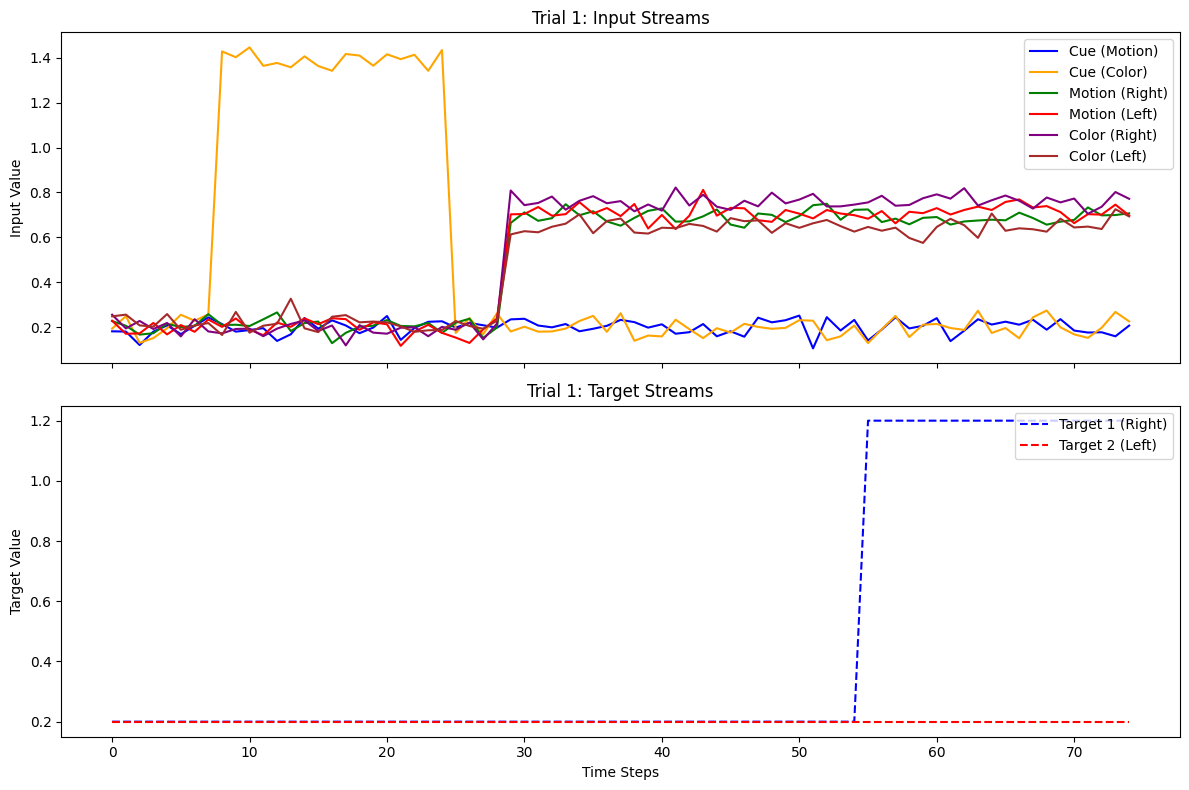

In [12]:
def visualize_trial(inputs, targets, trial_index):
    """
    Visualize the inputs and targets for a particular trial.
    
    :param inputs: Input data of shape (n_trials, n_t, 6)
    :param targets: Target data of shape (n_trials, n_t, 2)
    :param trial_index: Index of the trial to visualize
    """
    
    # Extract the inputs and targets for the given trial
    trial_inputs = inputs[trial_index].numpy()
    trial_targets = targets[trial_index].numpy()
    time_steps = trial_inputs.shape[0]
    
    # Create subplots for input and target streams
    fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

    # Plot the input streams
    axes[0].plot(range(time_steps), trial_inputs[:, 0], label='Cue (Motion)', color='blue')
    axes[0].plot(range(time_steps), trial_inputs[:, 1], label='Cue (Color)', color='orange')
    axes[0].plot(range(time_steps), trial_inputs[:, 2], label='Motion (Right)', color='green')
    axes[0].plot(range(time_steps), trial_inputs[:, 3], label='Motion (Left)', color='red')
    axes[0].plot(range(time_steps), trial_inputs[:, 4], label='Color (Right)', color='purple')
    axes[0].plot(range(time_steps), trial_inputs[:, 5], label='Color (Left)', color='brown')
    axes[0].set_title(f'Trial {trial_index}: Input Streams')
    axes[0].set_ylabel('Input Value')
    axes[0].legend(loc='upper right')
    
    # Plot the target streams
    axes[1].plot(range(time_steps), trial_targets[:, 0], label='Target 1 (Right)', color='blue', linestyle='--')
    axes[1].plot(range(time_steps), trial_targets[:, 1], label='Target 2 (Left)', color='red', linestyle='--')
    axes[1].set_title(f'Trial {trial_index}: Target Streams')
    axes[1].set_xlabel('Time Steps')
    axes[1].set_ylabel('Target Value')
    axes[1].legend(loc='upper right')
    
    plt.tight_layout()
    plt.show()

# Example usage (assuming inputs and targets are in torch.Tensor format):
visualize_trial(u, z, trial_index=1)


#### Initialize and fit RNN model with 50 units and Dales Law constraint.

In [13]:
net = Net(n=50, input_size=6, dale=True, sigma_rec=0.15 )
net.fit(u, z, mask, lr=.01,
        epochs=150, 
        verbose=True, 
        weight_decay=0.001)
# Note: Due to random initialization of network parameters, not every run will result in a successful network.

Epoch: 5/150............. mse_z: 0.0438
Epoch: 10/150............. mse_z: 0.0453
Epoch: 15/150............. mse_z: 0.0401
Epoch: 20/150............. mse_z: 0.0302
Epoch: 25/150............. mse_z: 0.0208
Epoch: 30/150............. mse_z: 0.0131
Epoch: 35/150............. mse_z: 0.0153
Epoch: 40/150............. mse_z: 0.0242
Epoch: 45/150............. mse_z: 0.0128
Epoch: 50/150............. mse_z: 0.0136
Epoch: 55/150............. mse_z: 0.0096
Epoch: 60/150............. mse_z: 0.0089
Epoch: 65/150............. mse_z: 0.0126
Epoch: 70/150............. mse_z: 0.0170
Epoch: 75/150............. mse_z: 0.0191
Epoch: 80/150............. mse_z: 0.0199
Epoch: 85/150............. mse_z: 0.0083
Epoch: 90/150............. mse_z: 0.0093
Epoch: 95/150............. mse_z: 0.0136
Epoch: 100/150............. mse_z: 0.0137
Epoch: 105/150............. mse_z: 0.0072
Epoch: 110/150............. mse_z: 0.0089
Epoch: 115/150............. mse_z: 0.0157
Epoch: 120/150............. mse_z: 0.0081
Epoch: 125/1

#### Visualize connectivity parameters of RNN after training

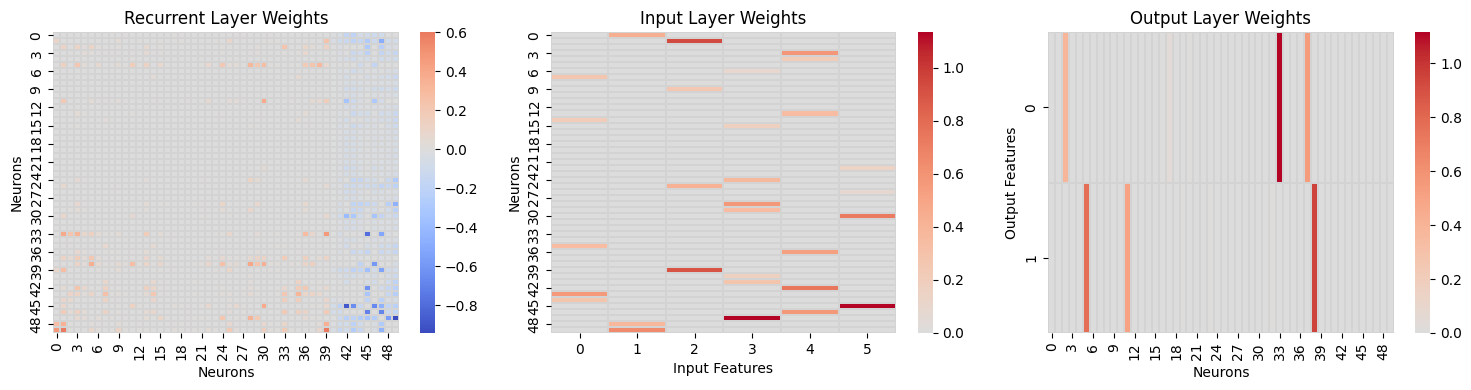

In [35]:
# Get the weight matrices
recurrent_weight_matrix = net.recurrent_layer.weight.data.detach().numpy()
input_weight_matrix = net.input_layer.weight.data.detach().numpy()
output_weight_matrix = net.output_layer.weight.data.detach().numpy()

# Create subplots to visualize all weight matrices
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Plot Recurrent Layer Weights
sns.heatmap(recurrent_weight_matrix, center=0, cmap='coolwarm', linewidths=0.1, linecolor='lightgray', ax=axes[0])
axes[0].set_title('Recurrent Layer Weights')
axes[0].set_xlabel('Neurons')
axes[0].set_ylabel('Neurons')

# Plot Input Layer Weights
sns.heatmap(input_weight_matrix, center=0, cmap='coolwarm', linewidths=0.1, linecolor='lightgray', ax=axes[1])
axes[1].set_title('Input Layer Weights')
axes[1].set_xlabel('Input Features')
axes[1].set_ylabel('Neurons')

# Plot Output Layer Weights
sns.heatmap(output_weight_matrix, center=0, cmap='coolwarm', linewidths=0.1, linecolor='lightgray', ax=axes[2])
axes[2].set_title('Output Layer Weights')
axes[2].set_xlabel('Neurons')
axes[2].set_ylabel('Output Features')

# Adjust layout for better visibility
plt.tight_layout()
plt.show()


#### weight examination and pruning

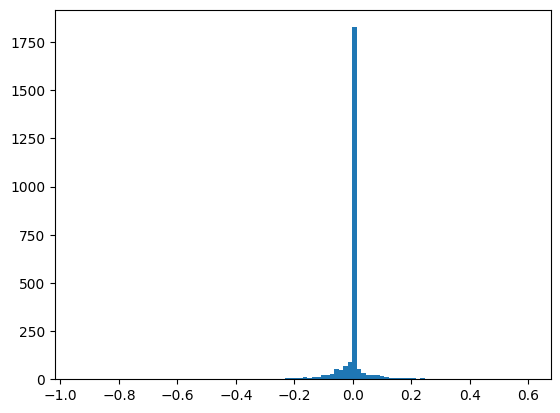

In [38]:
plt.hist(recurrent_weight_matrix.flatten(), bins=100);

In [23]:
def get_model_macs(model, inputs) -> int:
    return profile_macs(model, inputs)


def get_sparsity(tensor: torch.Tensor) -> float:
    """
    calculate the sparsity of the given tensor
        sparsity = #zeros / #elements = 1 - #nonzeros / #elements
    """
    return 1 - float(tensor.count_nonzero()) / tensor.numel()


def get_model_sparsity(model: nn.Module) -> float:
    """
    calculate the sparsity of the given model
        sparsity = #zeros / #elements = 1 - #nonzeros / #elements
    """
    num_nonzeros, num_elements = 0, 0
    for param in model.parameters():
        num_nonzeros += param.count_nonzero()
        num_elements += param.numel()
    return 1 - float(num_nonzeros) / num_elements

def get_num_parameters(model: nn.Module, count_nonzero_only=False) -> int:
    """
    calculate the total number of parameters of model
    :param count_nonzero_only: only count nonzero weights
    """
    num_counted_elements = 0
    for param in model.parameters():
        if count_nonzero_only:
            num_counted_elements += param.count_nonzero()
        else:
            num_counted_elements += param.numel()
    return num_counted_elements


def get_model_size(model: nn.Module, data_width=32, count_nonzero_only=False) -> int:
    """
    calculate the model size in bits
    :param data_width: #bits per element
    :param count_nonzero_only: only count nonzero weights
    """
    return get_num_parameters(model, count_nonzero_only) * data_width

Byte = 8
KiB = 1024 * Byte
MiB = 1024 * KiB
GiB = 1024 * MiB

In [40]:
def fine_grained_prune(tensor: torch.Tensor, sparsity : float) -> torch.Tensor:
    """
    magnitude-based pruning for single tensor
    :param tensor: torch.(cuda.)Tensor, weight of conv/fc layer
    :param sparsity: float, pruning sparsity
        sparsity = #zeros / #elements = 1 - #nonzeros / #elements
    :return:
        torch.(cuda.)Tensor, mask for zeros
    """
    sparsity = min(max(0.0, sparsity), 1.0)
    if sparsity == 1.0:
        tensor.zero_()
        return torch.zeros_like(tensor)
    elif sparsity == 0.0:
        return torch.ones_like(tensor)

    num_elements = tensor.numel()

    ##################### YOUR CODE STARTS HERE #####################
    # Step 1: calculate the #zeros (please use round())
    num_zeros = round(num_elements*sparsity)
    # Step 2: calculate the importance of weight
    importance = torch.abs(tensor)
    # Step 3: calculate the pruning threshold
    threshold = threshold = torch.kthvalue(importance.view(-1), num_zeros).values
    # Step 4: get binary mask (1 for nonzeros, 0 for zeros)
    mask = torch.gt(importance, threshold).type_as(tensor)
    ##################### YOUR CODE ENDS HERE #######################

    # Step 5: apply mask to prune the tensor
    tensor.mul_(mask)

    return mask

In [41]:
class FineGrainedPruner:
    def __init__(self, model, sparsity_dict):
        self.masks = FineGrainedPruner.prune(model, sparsity_dict)

    @torch.no_grad()
    def apply(self, model):
        for name, param in model.named_parameters():
            if name in self.masks:
                param *= self.masks[name]

    @staticmethod
    @torch.no_grad()
    def prune(model, sparsity_dict):
        masks = dict()
        for name, param in model.named_parameters():
            if param.dim() > 1: # we only prune conv and fc weights
                masks[name] = fine_grained_prune(param, sparsity_dict[name])
        return masks

#### Plot psychometric functions for trained RNN

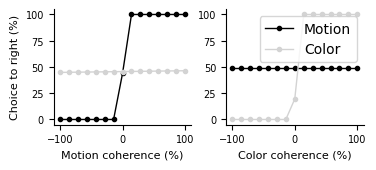

In [24]:

u, _, _, conditions  = generate_trials( n_trials=25,
                                                alpha=float(0.2),
                                                sigma_in=0.01,
                                                baseline=.2,
                                                n_coh=15)
df = psychometric(net,u,conditions)

## Fit latent circuit model to trained RNN

#### Initialize and fit latent circuit model

In [6]:
# Initialize
latent_net = LatentNet(n=8, N=net.n ,input_size=6, n_trials = u.shape[0],sigma_rec = 0.15)

# Generate inputs to simulate RNN
u, _, _, _  = generate_trials( n_trials=25,
                                                alpha=float(0.2),
                                                sigma_in=0.01,
                                                baseline=.2,
                                                n_coh=6)
# Simulate RNN
y = net(u)
z = net.output_layer(y)
# Fit latent circuit model
loss_history = latent_net.fit(u.detach(),z.detach(),y.detach(),epochs = 500,lr = .02,l_y = 1,weight_decay = 0.001)

Epoch: 0/500............. mse_z: 0.4512 nmse_y: 0.9125
Epoch: 10/500............. mse_z: 0.0520 nmse_y: 0.1752
Epoch: 20/500............. mse_z: 0.0289 nmse_y: 0.1226
Epoch: 30/500............. mse_z: 0.0376 nmse_y: 0.1319
Epoch: 40/500............. mse_z: 0.0225 nmse_y: 0.0776
Epoch: 50/500............. mse_z: 0.0242 nmse_y: 0.0796
Epoch: 60/500............. mse_z: 0.0206 nmse_y: 0.0719
Epoch: 70/500............. mse_z: 0.0205 nmse_y: 0.0717
Epoch: 80/500............. mse_z: 0.0211 nmse_y: 0.0739
Epoch: 90/500............. mse_z: 0.0250 nmse_y: 0.0853
Epoch: 100/500............. mse_z: 0.0249 nmse_y: 0.0856
Epoch: 110/500............. mse_z: 0.0223 nmse_y: 0.0744
Epoch: 120/500............. mse_z: 0.0229 nmse_y: 0.0768
Epoch: 130/500............. mse_z: 0.0226 nmse_y: 0.0790
Epoch: 140/500............. mse_z: 0.0233 nmse_y: 0.0762
Epoch: 150/500............. mse_z: 0.0202 nmse_y: 0.0726
Epoch: 160/500............. mse_z: 0.0263 nmse_y: 0.0916
Epoch: 170/500............. mse_z: 0.0208 

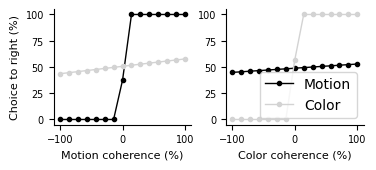

In [7]:
# Plot psychometric functions
u, z, mask, conditions  = generate_trials( n_trials=25,
                                                alpha=float(0.2),
                                                sigma_in=0.01,
                                                baseline=.2,
                                                n_coh=15)
df = psychometric(latent_net,u,conditions)

<AxesSubplot:>

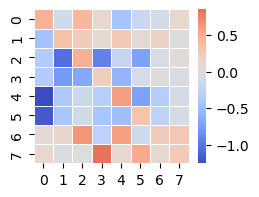

In [8]:
plt.figure(figsize=(2.5,2))
w_rec  = latent_net.recurrent_layer.weight.data.detach()
sns.heatmap(w_rec,center=0,cmap='coolwarm',linewidths=.5)

## Assessing fit quality of latent circuit model
There are several ways to assess the quality of fit of the latent circuit model.
1) Agreement between $Qx$ and $y$ where $x$ is the responses of the latent model, $y$ is the responses of the RNN and $Q$ is the orthonormal matrix that maps $x$ onto $y$.
2) Agreement between $x$ and $Q^Ty$ i.e. agreement in the subspace spanned by the columns of $Q$.
3) Agreement between $w_{rec}$ and $Q^TW_{rec}Q$.

#### 1) Agreement between $Qx$ and $y$

(-0.2075901307165623, 1.4979500897228717)

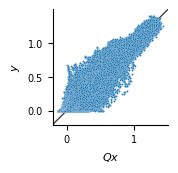

In [9]:
u, _, _, _  = generate_trials( n_trials=25,
                                                alpha=float(0.2),
                                                sigma_in=0.01,
                                                baseline=.2,
                                                n_coh=6)
y  = net(u).detach()
qx = latent_net(u)@latent_net.q
fig = plt.figure(figsize=(1.5,1.5))
gs = gridspec.GridSpec(1,1)
ax=fig.add_subplot(gs[0,0])
sns.scatterplot(x =qx.detach().flatten(),y = y.flatten(),ax=ax,s=2)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel("", fontsize=8)
ax.xaxis.set_tick_params(labelsize=7,bottom=True)
ax.yaxis.set_tick_params(labelsize=7,left=True)
ax.set_xlabel(r"$Qx$", fontsize=8)
ax.set_ylabel(r"$y$", fontsize=8)
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0,lw=1)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)

#### 2) Agreement between $x$ and $Q^Ty$

(-0.22601358592510223, 1.8837337017059326)

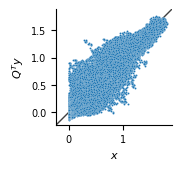

In [10]:
u, _, _, _  = generate_trials( n_trials=25,
                                                alpha=float(0.2),
                                                sigma_in=0.01,
                                                baseline=.2,
                                                n_coh=6)
qty  = net(u).detach()@latent_net.q.t()
x = latent_net(u)
fig = plt.figure(figsize=(1.5,1.5))
gs = gridspec.GridSpec(1,1)
ax=fig.add_subplot(gs[0,0])
sns.scatterplot(x =x.detach().flatten(),y = qty.detach().flatten(),ax=ax,s=2)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel("", fontsize=8)
ax.xaxis.set_tick_params(labelsize=7,bottom=True)
ax.yaxis.set_tick_params(labelsize=7,left=True)
ax.set_xlabel(r"$x$", fontsize=8)
ax.set_ylabel(r"$Q^Ty$", fontsize=8)
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0,lw=1)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)

#### 3) Agreement between $w_{rec}$ and $Q^TW_{rec}Q$

Text(0.5, 1.0, '$Q^Tw_{rec}Q$')

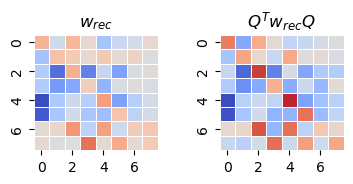

In [11]:
w_rec = latent_net.recurrent_layer.weight.data.detach()
q = latent_net.q.detach()
W_rec = net.recurrent_layer.weight.data.detach()

# Plot
fig = plt.figure(figsize=(4,1.5))
gs = gridspec.GridSpec(1,2,wspace = .5)
ax0=fig.add_subplot(gs[0,0])
ax1=fig.add_subplot(gs[0,1])

sns.heatmap(w_rec, ax=ax0, cmap='coolwarm',center=0,cbar=False,lw=.5)
ax0.set_title(r"$w_{rec}$")
sns.heatmap(q@W_rec@q.T, ax=ax1, cmap='coolwarm',center=0,cbar=False,lw=.5)
ax1.set_title(r"$Q^Tw_{rec}Q$")